In [3]:
import os
import random

import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from PIL import Image
from torchvision import models
from torch.utils.data import DataLoader, sampler, random_split
from torch.utils.data import Dataset,DataLoader


In [4]:
train_csv = pd.read_csv("drive/MyDrive/Colab Notebooks/train.csv")
train_csv.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
os.mkdir("drive/MyDrive/Colab Notebooks/training_images")
for i in list(set(train_csv["label"])):
    os.mkdir("drive/MyDrive/Colab Notebooks/training_images/{}".format(i))

In [ ]:
for file in tqdm(all_training_files):
    label = int(train_csv[train_csv["image_id"] == file]["label"])
    dirname = "drive/MyDrive/Colab Notebooks/train_images/" + file
    outname = "drive/MyDrive/Colab Notebooks/training_images/{}/{}".format(label, file)
    shutil.copyfile(dirname, outname)

In [6]:


data_dir = "drive/MyDrive/Colab Notebooks/training_images/"
batch_size = 8
def get_data_loaders(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((220, 220)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(20),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    all_data = datasets.ImageFolder(data_dir, transform=transform)  
    train_data_len = int(len(all_data)*0.75)
    valid_data_len = int(len(all_data) - train_data_len)
    train_data, val_data = random_split(all_data, [train_data_len, valid_data_len])
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    return ((train_loader, val_loader), all_data.classes)

In [9]:
get_data_loaders(data_dir, batch_size)

((<torch.utils.data.dataloader.DataLoader at 0x7fb1fb828f98>,
  <torch.utils.data.dataloader.DataLoader at 0x7fb1fb8287b8>),
 ['0', '1', '2', '3', '4'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

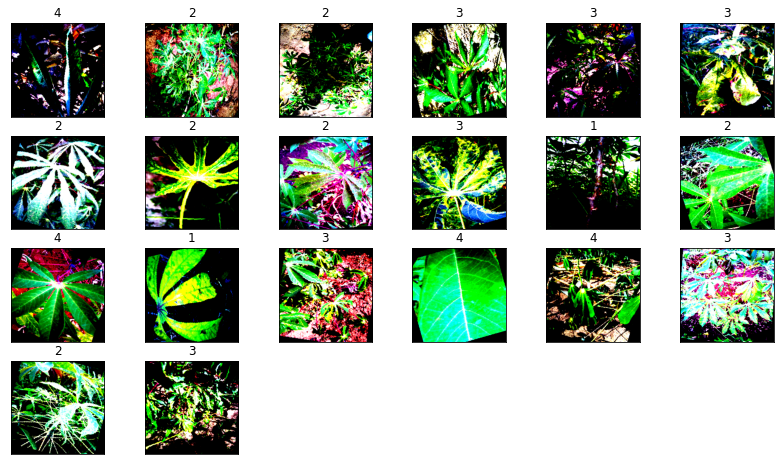

In [137]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(14, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(5, 12/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [12]:
imgs = 0
for n, (img, labels) in enumerate(train_loader):
  print(n, img.shape, labels.shape)
  imgs = img
  break

0 torch.Size([64, 3, 220, 220]) torch.Size([64])


In [63]:
import torch.nn.functional as F
from torch.autograd import Variable

class my_network(nn.Module):
  def __init__(self):
    super(my_network, self).__init__()
    self.conv1 = nn.Conv2d(3,30,3)
    self.conv2 = nn.Conv2d(30,64,3) 
    self.conv3 = nn.Conv2d(64,64,3) 
    self.conv4 = nn.Conv2d(64,64,3)
    self.conv5 = nn.Conv2d(64,64,3)
    self.conv6 = nn.Conv2d(64,64,3) 
    self.fc1 = nn.Linear(64*1*1, 30)
    self.fc2 = nn.Linear(30, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x), inplace=True)
    x = F.max_pool2d(x,(2,2))
    x = F.relu(self.conv2(x), inplace=True)
    x = F.max_pool2d(x,(2,2))
    x = F.relu(self.conv3(x), inplace=True)
    x = F.max_pool2d(x,(2,2))
    x = F.relu(self.conv4(x), inplace=True)
    x = F.max_pool2d(x,(2,2))
    x = F.relu(self.conv5(x), inplace=True)
    x = F.max_pool2d(x,(2,2))
    x = F.relu(self.conv6(x), inplace=True)
    x = F.max_pool2d(x,(2,2))
    
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x), inplace=True)
    x = F.relu(self.fc2(x), inplace=True)

    return x  

my_net = my_network()

In [64]:
optim = torch.optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# my_net.to(device)

epoch_num = 1
for epoch in range(epoch_num):
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    #inputs, labels = inputs.to(device), labels.to(device)
    #inputs, labels = Variable(inputs), Variable(labels)

    optim.zero_grad()
    out = my_net(inputs)
    loss = loss_function(out, labels)
    loss.backward()
    optim.step()

    if i % 64 == 0:
      print("%d => loss : %.3f" %(i, loss))
print("train over")


total = 0
correct = 0
my_net.to(device)
for data in val_loader:
  images, labels = data
  outputs = my_net(Variable(images))
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %f'%(100*correct/total))

0 => loss : 2.338
64 => loss : 2.308


In [ ]:
total = 0
correct = 0
my_net.to(device)
for data in val_loader:
  images, labels = data
  outputs = my_net(Variable(images))
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %f'%(100*correct/total))